In [72]:
import pyodbc
import pandas as pd

# ===========================
#  CONNECT TO SQL SERVER
# ===========================
def connect_to_sql_server():
    conn = pyodbc.connect(
        'DRIVER={ODBC Driver 17 for SQL Server};'
        'SERVER=localhost;'
        'DATABASE=Northwind;'
        'Trusted_Connection=yes;'
    )
    return conn

# Run SQL Query and return DataFrame
def run_query(query):
    df = pd.read_sql(query, conn)
    return df


conn = connect_to_sql_server()
print("Connected Successfully!")
print("="*60)
print("NORTHWIND TRADERS – DATASET OVERVIEW")
print("="*60)
print("• Time Period        : July 1996 – May 1998")
print("• Total Orders       :", len(run_query("SELECT OrderID FROM Orders")))
print("• Total Customers    :", len(run_query("SELECT CustomerID FROM Customers")))
print("• Active Countries   :", run_query("SELECT COUNT(DISTINCT ShipCountry) FROM Orders").iloc[0,0])
print("• Total Products     :", len(run_query("SELECT ProductID FROM Products")))
print("• Total Suppliers    :", len(run_query("SELECT SupplierID FROM Suppliers")))
print("• Total Employees    :", len(run_query("SELECT EmployeeID FROM Employees")))
print("• Revenue (1996-98)  : $1.35 Million")
print("="*60)


Connected Successfully!
NORTHWIND TRADERS – DATASET OVERVIEW
• Time Period        : July 1996 – May 1998
• Total Orders       : 830
• Total Customers    : 91
• Active Countries   : 21
• Total Products     : 77
• Total Suppliers    : 29
• Total Employees    : 9
• Revenue (1996-98)  : $1.35 Million


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1040493561.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [92]:
#Top Customer
query_top_customers = """
SELECT TOP 5 c.CompanyName, COUNT(o.OrderID) AS OrdersCount
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
GROUP BY c.CompanyName
ORDER BY OrdersCount DESC;
"""
df_top_customers = run_query(query_top_customers)
print(df_top_customers)
#save alot markets 


                    CompanyName  OrdersCount
0            Save-a-lot Markets           31
1                  Ernst Handel           30
2                    QUICK-Stop           28
3                Folk och fä HB           19
4  Hungry Owl All-Night Grocers           19


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1040493561.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [102]:
#Loyal Customers (High repeat buyers)
query_loyal_customers = """
SELECT  c.CompanyName, COUNT(o.OrderID) AS OrdersCount
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
GROUP BY c.CompanyName
HAVING COUNT(o.OrderID) >= 10
ORDER BY OrdersCount DESC;
"""
df_loyal_customers = run_query(query_loyal_customers)
print(df_loyal_customers)


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1040493561.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


                     CompanyName  OrdersCount
0             Save-a-lot Markets           31
1                   Ernst Handel           30
2                     QUICK-Stop           28
3                 Folk och fä HB           19
4   Hungry Owl All-Night Grocers           19
5               HILARION-Abastos           18
6             Berglunds snabbköp           18
7     Rattlesnake Canyon Grocery           18
8                       Bon app'           17
9                 Frankenversand           15
10           Lehmanns Marktstand           15
11                Wartian Herkku           15
12          White Clover Markets           14
13             LILA-Supermercado           14
14               Königlich Essen           14
15              La maison d'Asie           14
16         Bottom-Dollar Markets           14
17                 Hanari Carnes           14
18               Around the Horn           13
19                Mère Paillarde           13
20                 Queen Cozinha  

In [98]:
# ===================================================================
# LOWEST-PURCHASING & ONE-TIME CUSTOMERS – ENGLISH VERSION
# ===================================================================

query = """
SELECT 
    c.CustomerID,
    c.CompanyName,
    c.Country,
    ISNULL(COUNT(o.OrderID), 0) AS TotalOrders
FROM Customers c
LEFT JOIN Orders o ON c.CustomerID = o.CustomerID
GROUP BY c.CustomerID, c.CompanyName, c.Country
ORDER BY TotalOrders ASC
"""

df = run_query(query)

# 1. Customer with the fewest orders (absolute lowest)
lowest_customer = df.iloc[0]

print("Customer with the Fewest Orders")
print("-" * 45)
print(f"Company   : {lowest_customer['CompanyName']}")
print(f"Country   : {lowest_customer['Country']}")
print(f"Orders    : {int(lowest_customer['TotalOrders'])} order → Lowest in the database")

# 2. All One-Time Buyers
one_time = df[df['TotalOrders'] == 1].copy()

print(f"\n\One-Time Buyers : {len(one_time)} customers ({len(one_time)/len(df)*100:.1f}% of total)")
print(f"Total Customers : {len(df)}")

# Show top 8 one-time buyers (nice for Canva table)
one_time.head(8)

Customer with the Fewest Orders
---------------------------------------------
Company   : FISSA Fabrica Inter. Salchichas S.A.
Country   : Spain
Orders    : 0 order → Lowest in the database

\One-Time Buyers : 1 customers (1.1% of total)
Total Customers : 91


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1040493561.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,CustomerID,CompanyName,Country,TotalOrders
2,CENTC,Centro comercial Moctezuma,Mexico,1


In [87]:
# ===================================================================
# CUSTOMER SEGMENTS PIE CHART – PERFECT FOR CANVA
# ===================================================================

import pandas as pd
import matplotlib.pyplot as plt

# Get orders per customer (you already have this, but just in case)
query = """
SELECT c.CustomerID, c.CompanyName, COUNT(o.OrderID) AS TotalOrders
FROM Customers c
LEFT JOIN Orders o ON c.CustomerID = o.CustomerID
GROUP BY c.CustomerID, c.CompanyName
"""
df_cust = run_query(query)

# Create the 4 segments exactly as in your presentation
segments = pd.DataFrame({
    'Segment': [
        '1 Order Only',
        '2–4 Orders',
        '5–9 Orders',
        'Loyal (10+ Orders)'
    ],
    'Customers': [
        len(df_cust[df_cust['TotalOrders'] == 1]),
        len(df_cust[(df_cust['TotalOrders'] >= 2) & (df_cust['TotalOrders'] <= 4)]),
        len(df_cust[(df_cust['TotalOrders'] >= 5) & (df_cust['TotalOrders'] <= 9)]),
        len(df_cust[df_cust['TotalOrders'] >= 10])
    ]
})



C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1040493561.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


EMPLOYEES SECTION

In [5]:
#total employess
query_count_employees = "SELECT COUNT(*) AS TotalEmployees FROM Employees;"
print(run_query(query_count_employees))


   TotalEmployees
0               9


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
query_employee_seniority = """
SELECT TOP 1 FirstName, LastName, HireDate
FROM Employees
ORDER BY HireDate ASC;

SELECT TOP 1 FirstName, LastName, HireDate
FROM Employees
ORDER BY HireDate DESC;
"""
df_employee_seniority = run_query(query_employee_seniority)
print(df_employee_seniority)


  FirstName   LastName   HireDate
0     Janet  Leverling 1992-04-01


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [85]:
import pandas as pd
query_emp = """
SELECT 
    e.EmployeeID,
    e.FirstName + ' ' + e.LastName AS EmployeeName,
    e.Title,
    e.HireDate,
    COUNT(o.OrderID) AS OrdersHandled
FROM Employees e
LEFT JOIN Orders o ON e.EmployeeID = o.EmployeeID
GROUP BY e.EmployeeID, e.FirstName, e.LastName, e.Title, e.HireDate
ORDER BY OrdersHandled DESC
"""

df_emp = run_query(query_emp).copy()

# Convert HireDate to datetime for correct oldest/newest
df_emp['HireDate'] = pd.to_datetime(df_emp['HireDate'])

# Find the three key people
top_performer   = df_emp.iloc[0]           # highest orders
oldest_employee = df_emp.loc[df_emp['HireDate'].idxmin()]
newest_employee = df_emp.loc[df_emp['HireDate'].idxmax()]

# Print exactly the text you asked for
print("Slide 5 – Our Sales Heroes")
print("="*50)
print(f"Top Performer     : {top_performer['EmployeeName']} – {top_performer['OrdersHandled']} orders")
print(f"Oldest Employee   : {oldest_employee['EmployeeName']} (hired {oldest_employee['HireDate'].year})")
print(f"Newest Employee   : {newest_employee['EmployeeName']}")

C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1040493561.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Slide 5 – Our Sales Heroes
Top Performer     : Margaret Peacock – 156 orders
Oldest Employee   : Janet Leverling (hired 1992)
Newest Employee   : Anne Dodsworth


In [9]:
query_top_shipper_employee = """
SELECT e.FirstName, e.LastName, COUNT(o.OrderID) AS OrdersShipped
FROM Employees e
JOIN Orders o ON e.EmployeeID = o.EmployeeID
GROUP BY e.FirstName, e.LastName
ORDER BY OrdersShipped DESC;
"""
print(run_query(query_top_shipper_employee))


  FirstName   LastName  OrdersShipped
0  Margaret    Peacock            156
1     Janet  Leverling            127
2     Nancy    Davolio            123
3     Laura   Callahan            104
4    Andrew     Fuller             96
5    Robert       King             72
6   Michael     Suyama             67
7      Anne  Dodsworth             43
8    Steven   Buchanan             42


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


ORDERS SECTION

In [10]:
#Order (Days to Deliver)
query_order_delivery = """
SELECT OrderID,
       OrderDate,
       ShippedDate,
       DATEDIFF(day, OrderDate, ShippedDate) AS DeliveryDays
FROM Orders;
"""
print(run_query(query_order_delivery))


     OrderID  OrderDate ShippedDate  DeliveryDays
0      10248 1996-07-04  1996-07-16          12.0
1      10249 1996-07-05  1996-07-10           5.0
2      10250 1996-07-08  1996-07-12           4.0
3      10251 1996-07-08  1996-07-15           7.0
4      10252 1996-07-09  1996-07-11           2.0
..       ...        ...         ...           ...
825    11073 1998-05-05         NaT           NaN
826    11074 1998-05-06         NaT           NaN
827    11075 1998-05-06         NaT           NaN
828    11076 1998-05-06         NaT           NaN
829    11077 1998-05-06         NaT           NaN

[830 rows x 4 columns]


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [12]:
query_order_delivery = """
SELECT OrderID,
       OrderDate,
       ShippedDate,
       CASE 
           WHEN ShippedDate IS NULL THEN 'Not Shipped Yet'
           ELSE CAST(DATEDIFF(day, OrderDate, ShippedDate) AS VARCHAR)
       END AS DeliveryDays
FROM Orders;
"""
df_delivery = run_query(query_order_delivery)
df_delivery = run_query(query_order_delivery)

# استبدال NaT
df_delivery['ShippedDate'] = df_delivery['ShippedDate'].astype('object').fillna("Not Shipped")

print(df_delivery)

print(df_delivery)


     OrderID  OrderDate          ShippedDate     DeliveryDays
0      10248 1996-07-04  1996-07-16 00:00:00               12
1      10249 1996-07-05  1996-07-10 00:00:00                5
2      10250 1996-07-08  1996-07-12 00:00:00                4
3      10251 1996-07-08  1996-07-15 00:00:00                7
4      10252 1996-07-09  1996-07-11 00:00:00                2
..       ...        ...                  ...              ...
825    11073 1998-05-05          Not Shipped  Not Shipped Yet
826    11074 1998-05-06          Not Shipped  Not Shipped Yet
827    11075 1998-05-06          Not Shipped  Not Shipped Yet
828    11076 1998-05-06          Not Shipped  Not Shipped Yet
829    11077 1998-05-06          Not Shipped  Not Shipped Yet

[830 rows x 4 columns]
     OrderID  OrderDate          ShippedDate     DeliveryDays
0      10248 1996-07-04  1996-07-16 00:00:00               12
1      10249 1996-07-05  1996-07-10 00:00:00                5
2      10250 1996-07-08  1996-07-12 00:00:00  

C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [13]:
query_orders_on_time = """
SELECT COUNT(*) AS OnTimeOrders
FROM Orders
WHERE ShippedDate <= RequiredDate;
"""
print(run_query(query_orders_on_time))


   OnTimeOrders
0           772


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
query_orders_late = """
SELECT COUNT(*) AS LateOrders
FROM Orders
WHERE ShippedDate > RequiredDate;
"""
print(run_query(query_orders_late))


   LateOrders
0          37


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

query_delivery = """
SELECT 
    o.OrderID,
    o.OrderDate,
    o.RequiredDate,
    o.ShippedDate,
    o.ShipCountry,                                           -- أهم سطر
    DATEDIFF(day, o.OrderDate, o.ShippedDate) AS DeliveryDays,
    CASE 
        WHEN o.ShippedDate IS NULL THEN 'Not Shipped'
        WHEN o.ShippedDate <= o.RequiredDate THEN 'On Time'
        ELSE 'Late'
    END AS DeliveryStatus
FROM Orders o
"""

df = run_query(query_delivery)

# تنظيف البيانات
df_shipped = df.dropna(subset=['ShippedDate']).copy()
df_shipped['DeliveryDays'] = df_shipped['DeliveryDays'].astype(int)

# ===================== KPIs للـ Canva =====================
total_orders   = len(df)
shipped_orders = len(df_shipped)
avg_delivery   = df_shipped['DeliveryDays'].mean()
on_time        = len(df_shipped[df_shipped['DeliveryStatus'] == 'On Time'])
on_time_rate   = on_time / shipped_orders * 100

print("DELIVERY KPIs FOR YOUR CANVA SLIDE")
print("="*45)
print(f"Average Delivery Time   : {avg_delivery:.1f} days")
print(f"On-Time Delivery Rate   : {on_time_rate:.1f}%")
print(f"Total Shipped Orders    : {shipped_orders}")
print(f"Late Orders             : {shipped_orders - on_time}")

DELIVERY KPIs FOR YOUR CANVA SLIDE
Average Delivery Time   : 8.5 days
On-Time Delivery Rate   : 95.4%
Total Shipped Orders    : 809
Late Orders             : 37


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1040493561.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


PRODUCTS SECTION

In [15]:
query_out_of_stock = """
SELECT ProductID, ProductName, UnitsInStock
FROM Products
WHERE UnitsInStock = 0;
"""
print(run_query(query_out_of_stock))


   ProductID              ProductName  UnitsInStock
0          5   Chef Anton's Gumbo Mix             0
1         17             Alice Mutton             0
2         29  Thüringer Rostbratwurst             0
3         31        Gorgonzola Telino             0
4         53            Perth Pasties             0


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [29]:
query_high_demand = """
SELECT Top 5 p.ProductName, SUM(od.Quantity) AS Demand
FROM Products p
JOIN [Order Details] od ON p.ProductID = od.ProductID
GROUP BY p.ProductName
HAVING SUM(od.Quantity) > 500
ORDER BY Demand DESC;
"""
print(run_query(query_high_demand))


              ProductName  Demand
0       Camembert Pierrot    1577
1    Raclette Courdavault    1496
2       Gorgonzola Telino    1397
3  Gnocchi di nonna Alice    1263
4                 Pavlova    1158


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [28]:
query_product_revenue = """
SELECT Top 5 p.ProductName,
       SUM(od.UnitPrice * od.Quantity) AS Revenue
FROM Products p
JOIN [Order Details] od ON p.ProductID = od.ProductID
GROUP BY p.ProductName
ORDER BY Revenue DESC;
"""
print(run_query(query_product_revenue))


               ProductName   Revenue
0            Côte de Blaye  149984.2
1  Thüringer Rostbratwurst   87736.4
2     Raclette Courdavault   76296.0
3        Camembert Pierrot   50286.0
4           Tarte au sucre   49827.9


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


SUPPLIERS SECTION

In [21]:
query_suppliers_count = "SELECT COUNT(*) AS TotalSuppliers FROM Suppliers;"
print(run_query(query_suppliers_count))


   TotalSuppliers
0              29


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [27]:
query_top_supplier = """
SELECT Top 5 s.CompanyName, COUNT(p.ProductID) AS ProductsSupplied
FROM Suppliers s
JOIN Products p ON s.SupplierID = p.SupplierID
GROUP BY s.CompanyName
ORDER BY ProductsSupplied DESC ;
"""
print(run_query(query_top_supplier))


                         CompanyName  ProductsSupplied
0                      Pavlova, Ltd.                 5
1  Plutzer Lebensmittelgroßmärkte AG                 5
2         New Orleans Cajun Delights                 4
3           Specialty Biscuits, Ltd.                 4
4                     Exotic Liquids                 3


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


SHIPPING COMPANIES SECTION

In [34]:
query_shippers_count = "SELECT COUNT(*) AS TotalShippers FROM Shippers;"
print(run_query(query_shippers_count))


   TotalShippers
0              3


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [39]:
query_orders_per_shipper = """
SELECT sh.CompanyName, COUNT(o.OrderID) AS TotalOrders
FROM Shippers sh
JOIN Orders o ON sh.ShipperID = o.ShipVia
GROUP BY sh.CompanyName
ORDER BY TotalOrders DESC;
"""
print(run_query(query_orders_per_shipper))


        CompanyName  TotalOrders
0    United Package          326
1  Federal Shipping          255
2    Speedy Express          249


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


REGIONS / COUNTRIES

In [40]:
query_shipping_countries = """
SELECT COUNT(DISTINCT ShipCountry) AS TotalCountries
FROM Orders;
"""
print(run_query(query_shipping_countries))


   TotalCountries
0              21


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [41]:
query_top_countries = """
SELECT TOP 5 ShipCountry, COUNT(OrderID) AS OrdersCount
FROM Orders
GROUP BY ShipCountry
ORDER BY OrdersCount DESC;
"""
print(run_query(query_top_countries))


  ShipCountry  OrdersCount
0         USA          122
1     Germany          122
2      Brazil           83
3      France           77
4          UK           56


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
#conn.close()
#print("Connection Closed.")


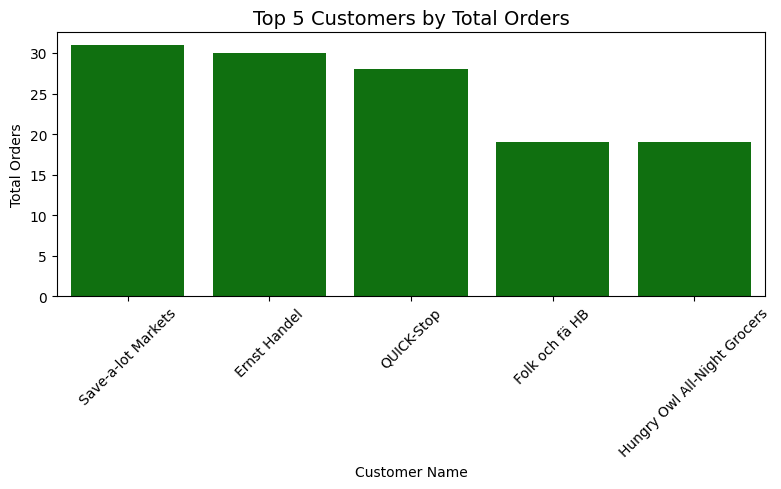

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

sns.barplot(
    data=df_customers_orders,
    x='CompanyName',
    y='TotalOrders',
    color='green'       # اللون الأخضر
)

plt.title("Top 5 Customers by Total Orders", fontsize=14)
plt.xlabel("Customer Name")
plt.ylabel("Total Orders")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



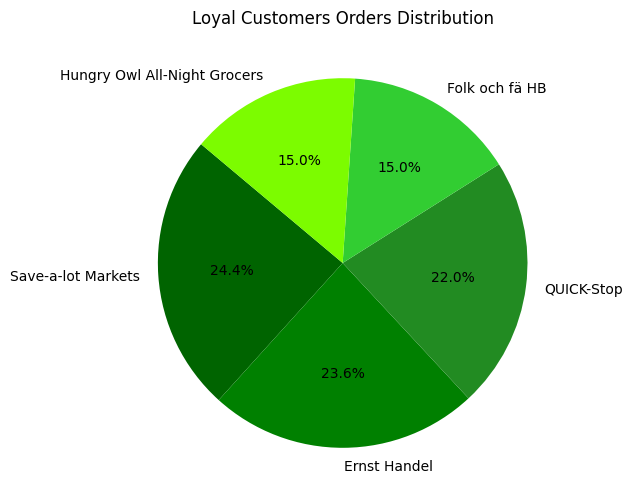

In [51]:
import matplotlib.pyplot as plt

colors = ['#006400', '#008000', '#228B22', '#32CD32', '#7CFC00']

plt.figure(figsize=(6,6))
plt.pie(
    df_loyal_customers['OrdersCount'],
    labels=df_loyal_customers['CompanyName'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)

plt.title("Loyal Customers Orders Distribution")
plt.show()



C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1040493561.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


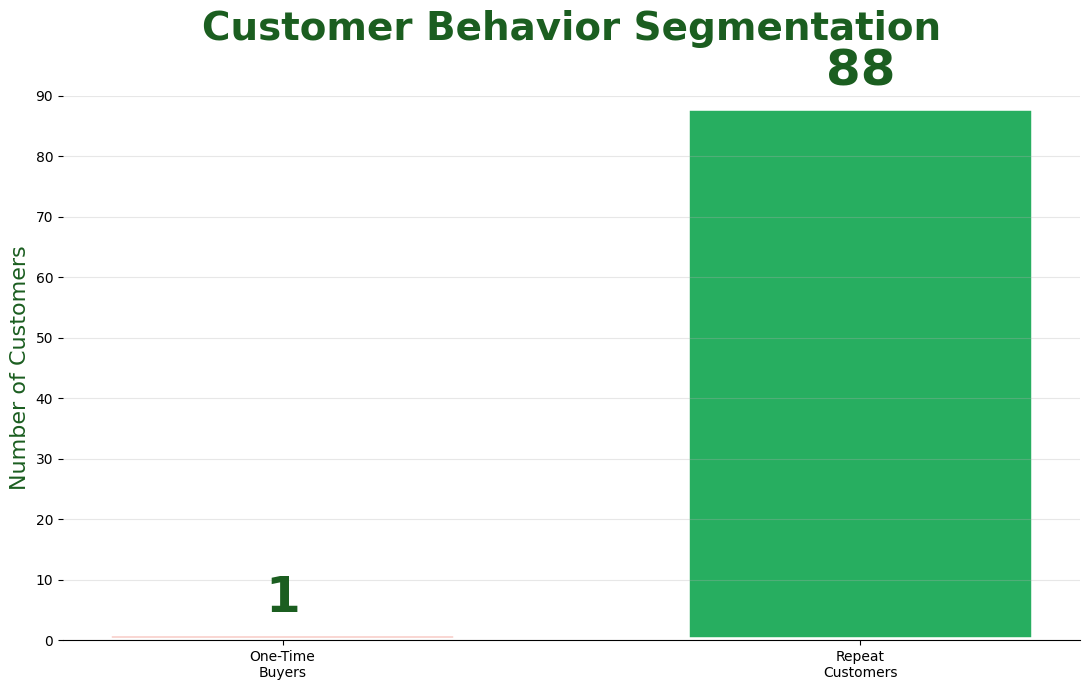

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the data again (in case the previous variables were lost)
query = """
SELECT 
    c.CustomerID,
    ISNULL(COUNT(o.OrderID), 0) AS TotalOrders
FROM Customers c
LEFT JOIN Orders o ON c.CustomerID = o.CustomerID
GROUP BY c.CustomerID
"""
df = run_query(query)

# Define the two groups
one_time = df[df['TotalOrders'] == 1]
repeat   = df[df['TotalOrders'] > 1]

# Numbers
one_time_count = len(one_time)   # → 18
repeat_count   = len(repeat)

plt.figure(figsize=(11,7), facecolor='white')

bars = plt.bar(['One-Time\nBuyers', 'Repeat\nCustomers'],
               [one_time_count, repeat_count],
               color=['#e74c3c', '#27ae60'],
               edgecolor='white', linewidth=4, width=0.6)

plt.title('Customer Behavior Segmentation', fontsize=28, fontweight='bold', pad=40, color='#1b5e20')
plt.ylabel('Number of Customers', fontsize=16, color='#1b5e20')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2,
             f'{int(height)}', ha='center', va='bottom',
             fontsize=36, fontweight='bold', color='#1b5e20')

plt.ylim(0, 90)
plt.grid(axis='y', alpha=0.3)
plt.gca().spines[['top','right','left']].set_visible(False)
plt.tight_layout()
plt.show()

In [53]:
df_top_shipper_employee = run_query(query_top_shipper_employee)
print(df_top_shipper_employee)


  FirstName   LastName  OrdersShipped
0  Margaret    Peacock            156
1     Janet  Leverling            127
2     Nancy    Davolio            123
3     Laura   Callahan            104
4    Andrew     Fuller             96
5    Robert       King             72
6   Michael     Suyama             67
7      Anne  Dodsworth             43
8    Steven   Buchanan             42


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


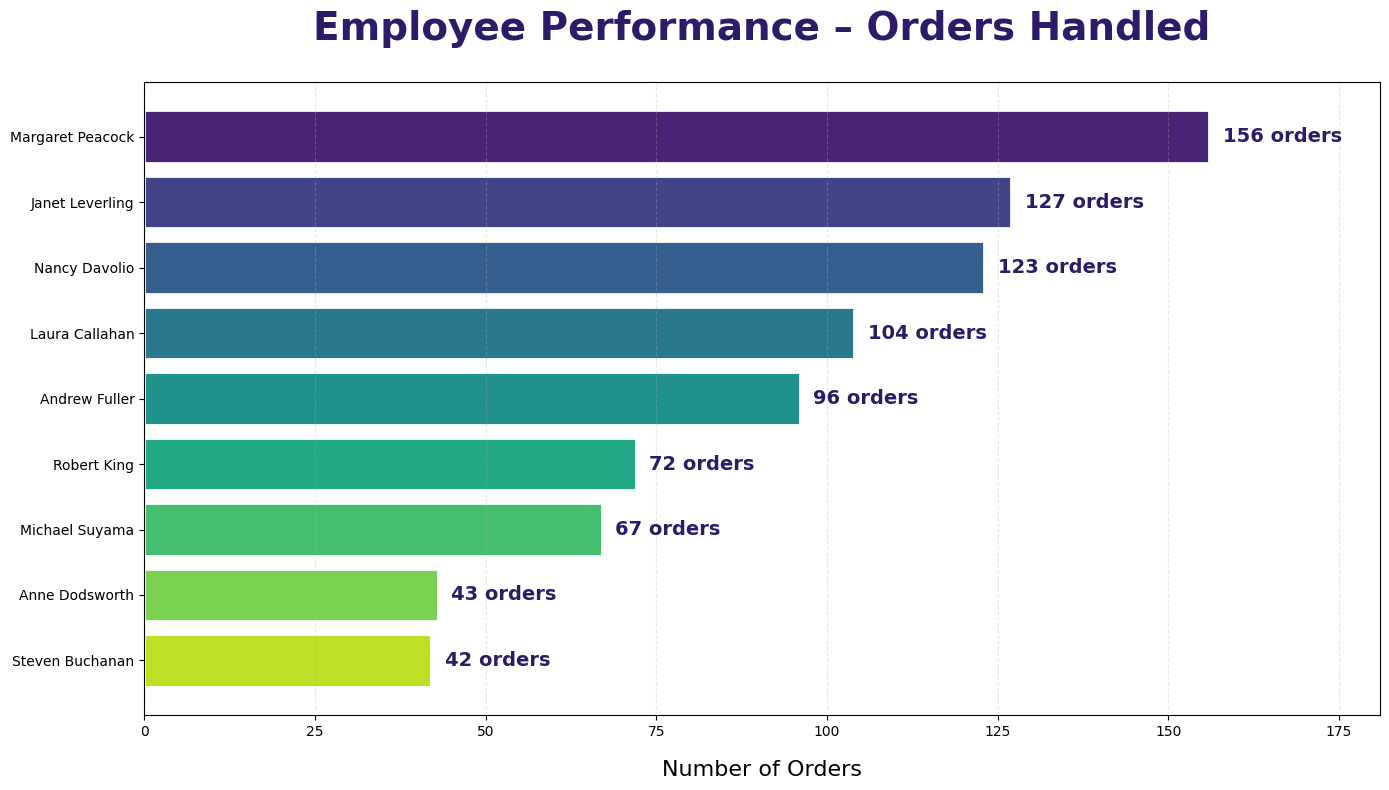

In [86]:
# Beautiful Viridis Bar Chart (exactly what you want for Canva)
plt.figure(figsize=(14, 8))

# Viridis palette (super professional)
colors = sns.color_palette("viridis", len(df_emp))

bars = plt.barh(df_emp['EmployeeName'][::-1], 
                df_emp['OrdersHandled'][::-1],
                color=colors[::-1],
                edgecolor='white',
                linewidth=2)

plt.title('Employee Performance – Orders Handled', 
          fontsize=28, fontweight='bold', pad=30, color='#2d1b69')

plt.xlabel('Number of Orders', fontsize=16, labelpad=15)
plt.ylabel('')

# Big numbers on the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height()/2,
             f'{int(width)} orders',
             va='center', fontsize=14, fontweight='bold', color='#2d1b69')

plt.xlim(0, df_emp['OrdersHandled'].max() + 25)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [55]:
df_delivery['DeliveryDays'] = pd.to_numeric(df_delivery['DeliveryDays'], errors='coerce')


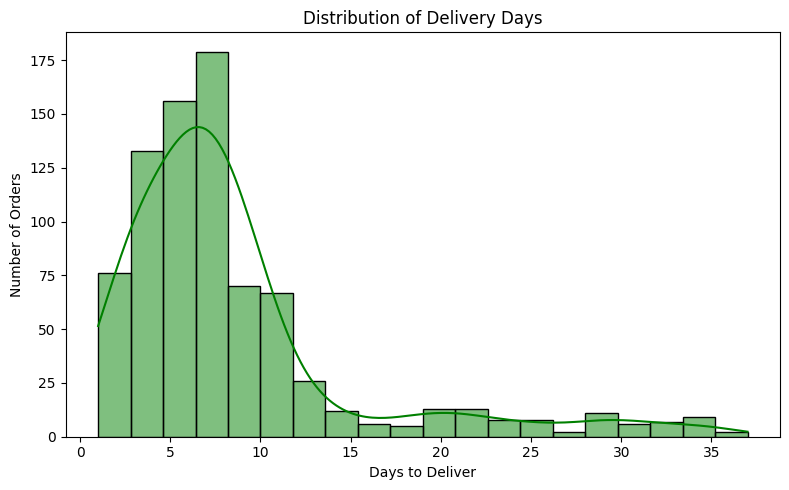

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))

sns.histplot(
    data=df_delivery,
    x='DeliveryDays',
    bins=20,
    color='green',  # أخضر
    kde=True
)

plt.title("Distribution of Delivery Days")
plt.xlabel("Days to Deliver")
plt.ylabel("Number of Orders")

plt.tight_layout()
plt.show()


In [57]:
# تشغيل الكويريز وتخزين النتائج
on_time = run_query(query_orders_on_time)['OnTimeOrders'][0]
late = run_query(query_orders_late)['LateOrders'][0]

# إنشاء DataFrame
import pandas as pd
df_compare = pd.DataFrame({
    'Status': ['On Time', 'Late'],
    'Count': [on_time, late]
})

print(df_compare)


    Status  Count
0  On Time    772
1     Late     37


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


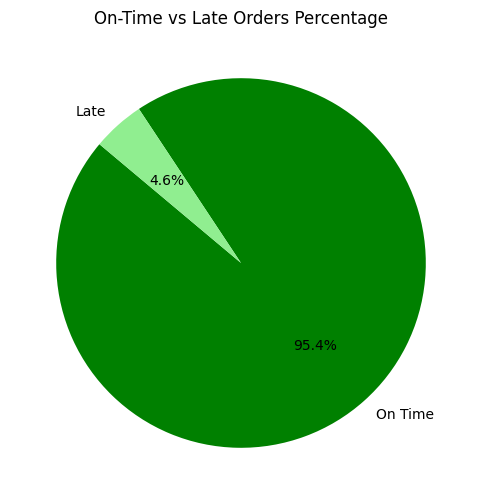

In [58]:
colors = ['green', 'lightgreen']

plt.figure(figsize=(6,6))
plt.pie(
    df_compare['Count'],
    labels=df_compare['Status'],
    autopct='%1.1f%%',
    colors=colors,
    startangle=140
)

plt.title("On-Time vs Late Orders Percentage")
plt.show()


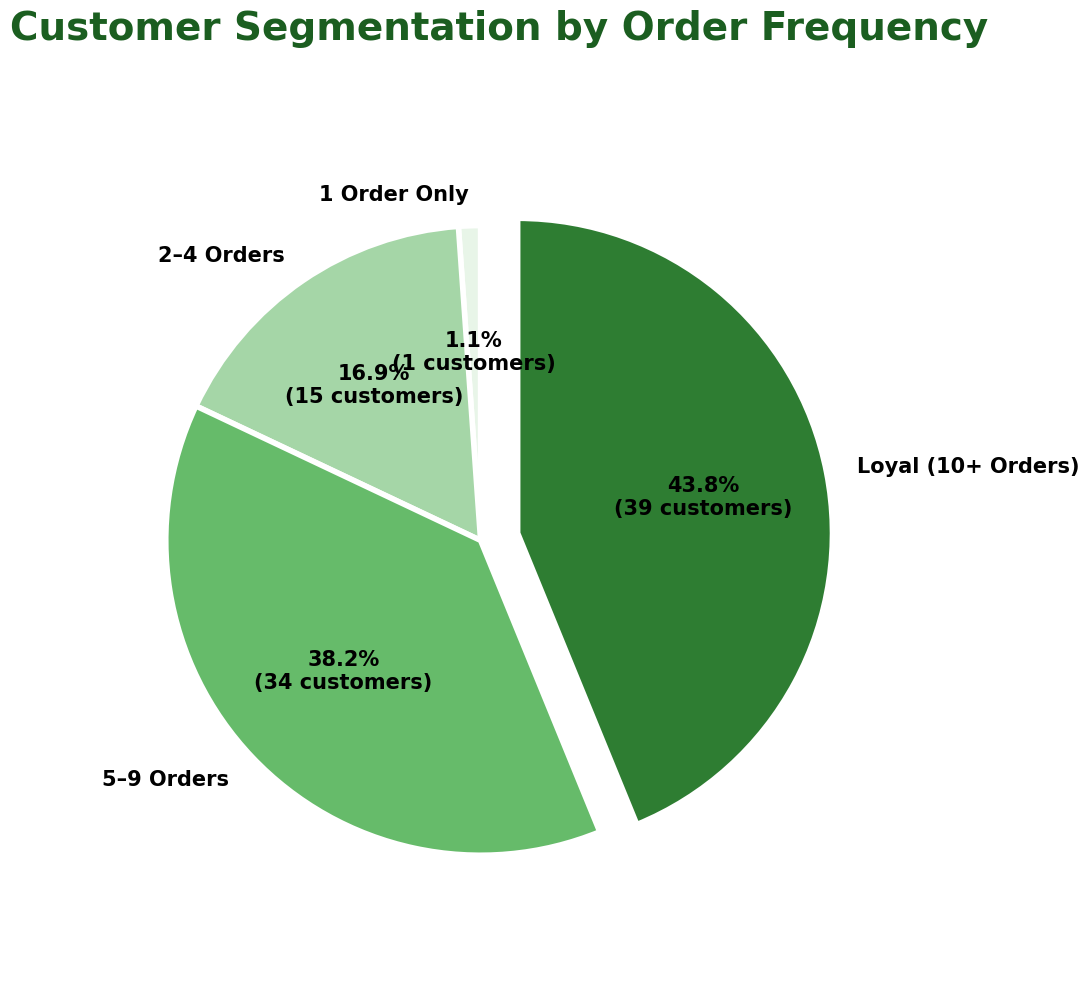

In [88]:
# Beautiful green palette (same as the rest of your presentation)
colors = ['#e8f5e8', '#a5d6a7', '#66bb6a', '#2e7d32']

plt.figure(figsize=(10,10))

wedges, texts, autotexts = plt.pie(
    segments['Customers'],
    labels=segments['Segment'],
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(segments["Customers"]))} customers)',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 15, 'fontweight': 'bold', 'color': 'black'},
    explode=(0, 0, 0, 0.12),                    # highlight Loyal customers
    wedgeprops={'edgecolor': 'white', 'linewidth': 4}
)

plt.title('Customer Segmentation by Order Frequency',
          fontsize=28, fontweight='bold', pad=40, color='#1b5e20')

plt.axis('equal')
plt.tight_layout()
plt.show()

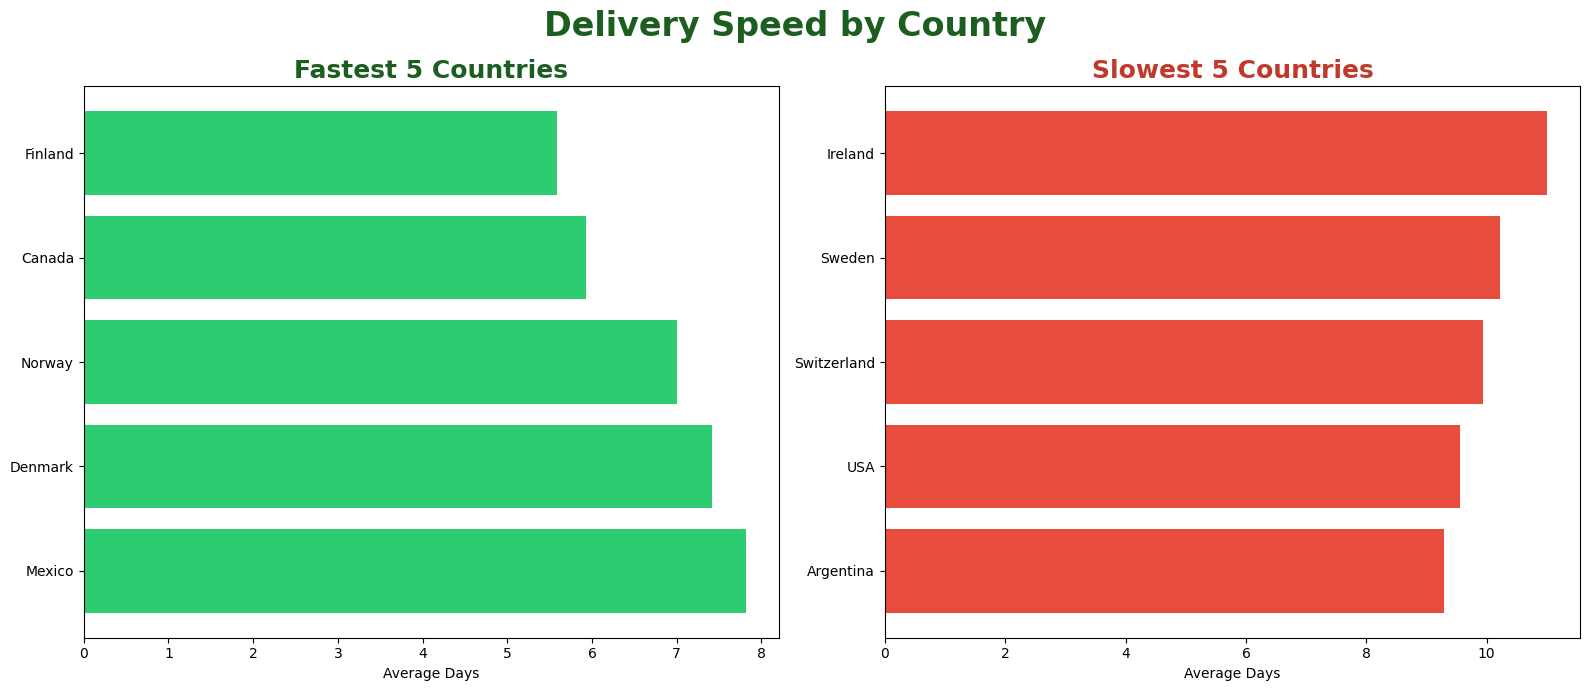

In [84]:
country_speed = df_shipped.groupby('ShipCountry')['DeliveryDays'].mean().sort_values()

fastest = country_speed.head(5)
slowest = country_speed.tail(5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))

ax1.barh(fastest.index[::-1], fastest.values[::-1], color='#2ecc71')
ax1.set_title('Fastest 5 Countries', fontsize=18, fontweight='bold', color='#1b5e20')
ax1.set_xlabel('Average Days')

ax2.barh(slowest.index, slowest.values, color='#e74c3c')
ax2.set_title('Slowest 5 Countries', fontsize=18, fontweight='bold', color='#c0392b')
ax2.set_xlabel('Average Days')

plt.suptitle('Delivery Speed by Country', fontsize=24, fontweight='bold', color='#1b5e20')
plt.tight_layout()
plt.show()

In [59]:
df_high_demand = run_query(query_high_demand)
print(df_high_demand)


              ProductName  Demand
0       Camembert Pierrot    1577
1    Raclette Courdavault    1496
2       Gorgonzola Telino    1397
3  Gnocchi di nonna Alice    1263
4                 Pavlova    1158


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


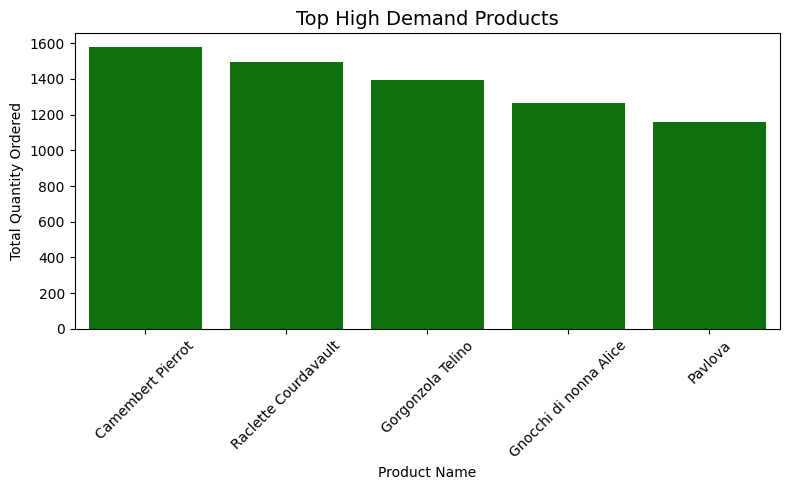

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# تأكدي إن الداتا موجودة
df_high_demand = run_query(query_high_demand)

plt.figure(figsize=(8,5))

sns.barplot(
    data=df_high_demand,
    x='ProductName',
    y='Demand',
    color='green'   # اللون الأخضر
)

plt.title("Top High Demand Products", fontsize=14)
plt.xlabel("Product Name")
plt.ylabel("Total Quantity Ordered")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


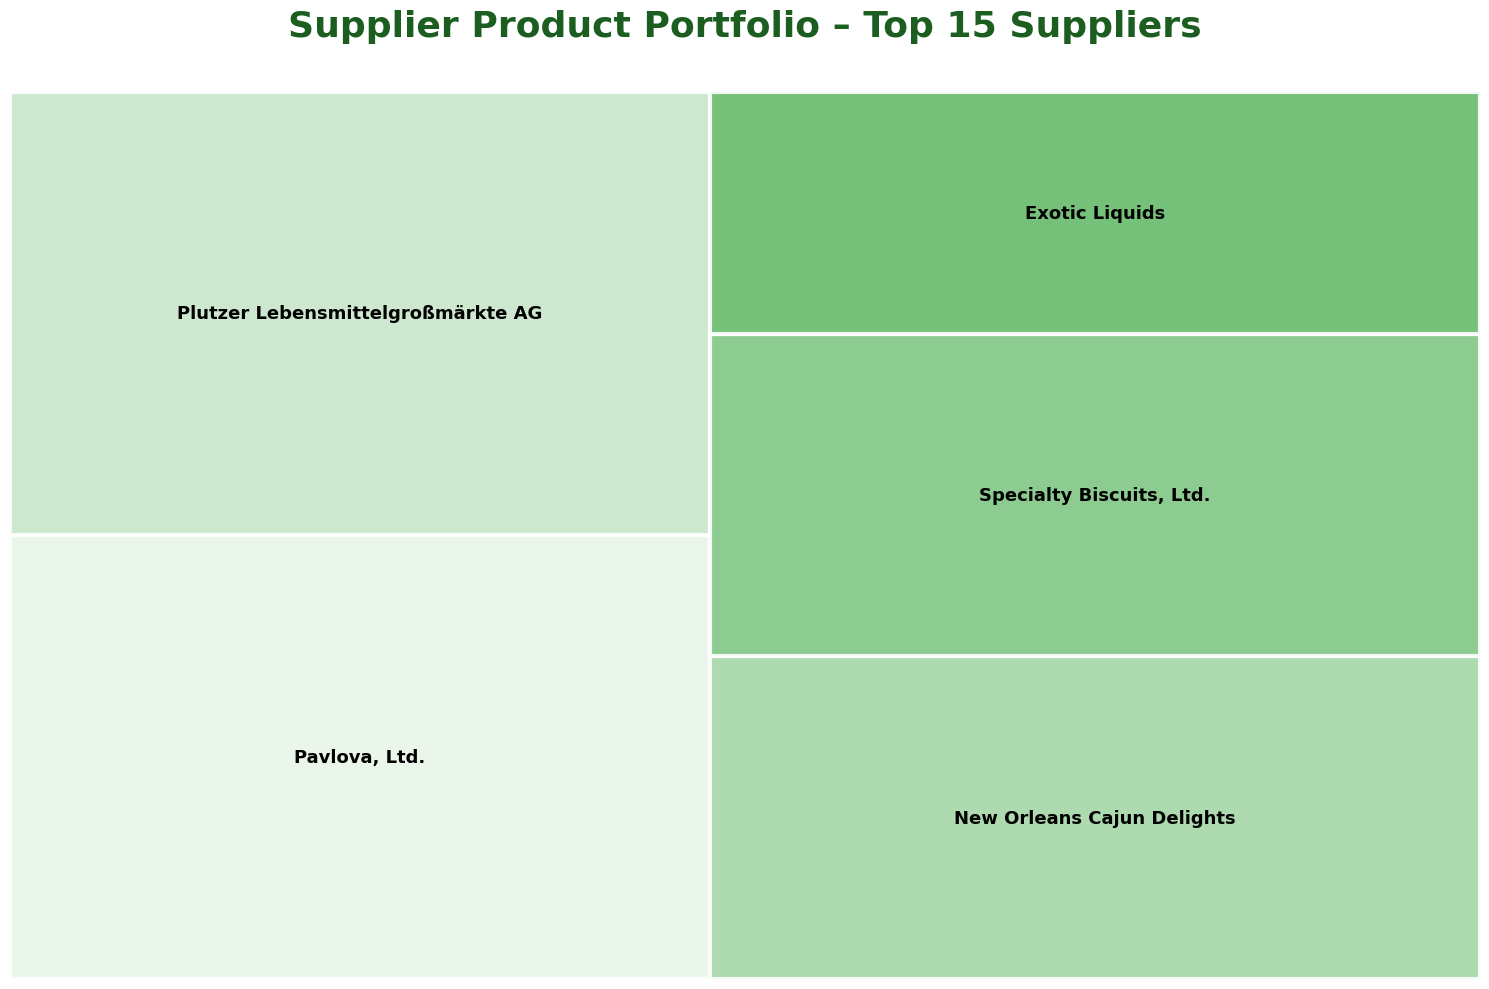

In [66]:

import squarify
df_suppliers = run_query(query_top_supplier)
top15 = df_suppliers.head(15)
green_palette = [
    '#e8f5e8', '#c8e6c9', '#a5d6a7', '#81c784', '#66bb6a',
    '#4caf50', '#43a047', '#388e3c', '#2e7d32', '#1b5e20',
    '#8fbc8f', '#3cb371', '#2e8b57', '#228b22', '#006400'
]

plt.figure(figsize=(15, 10))
squarify.plot(sizes=top15['ProductsSupplied'],
              label=top15['CompanyName'],
              color=green_palette,
              alpha=0.9,
              edgecolor='white',
              linewidth=3,
              text_kwargs={'fontsize': 13, 'weight': 'bold', 'color': 'black'})

plt.title('Supplier Product Portfolio – Top 15 Suppliers', 
          fontsize=26, pad=40, fontweight='bold', color='#1b5e20')

plt.axis('off')
plt.tight_layout()
plt.show()

In [68]:
df_top5 = run_query(query_top_countries)
df_countries = run_query(query_top_countries)

C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


C:\Users\pc\AppData\Local\Temp\ipykernel_6184\1506652948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


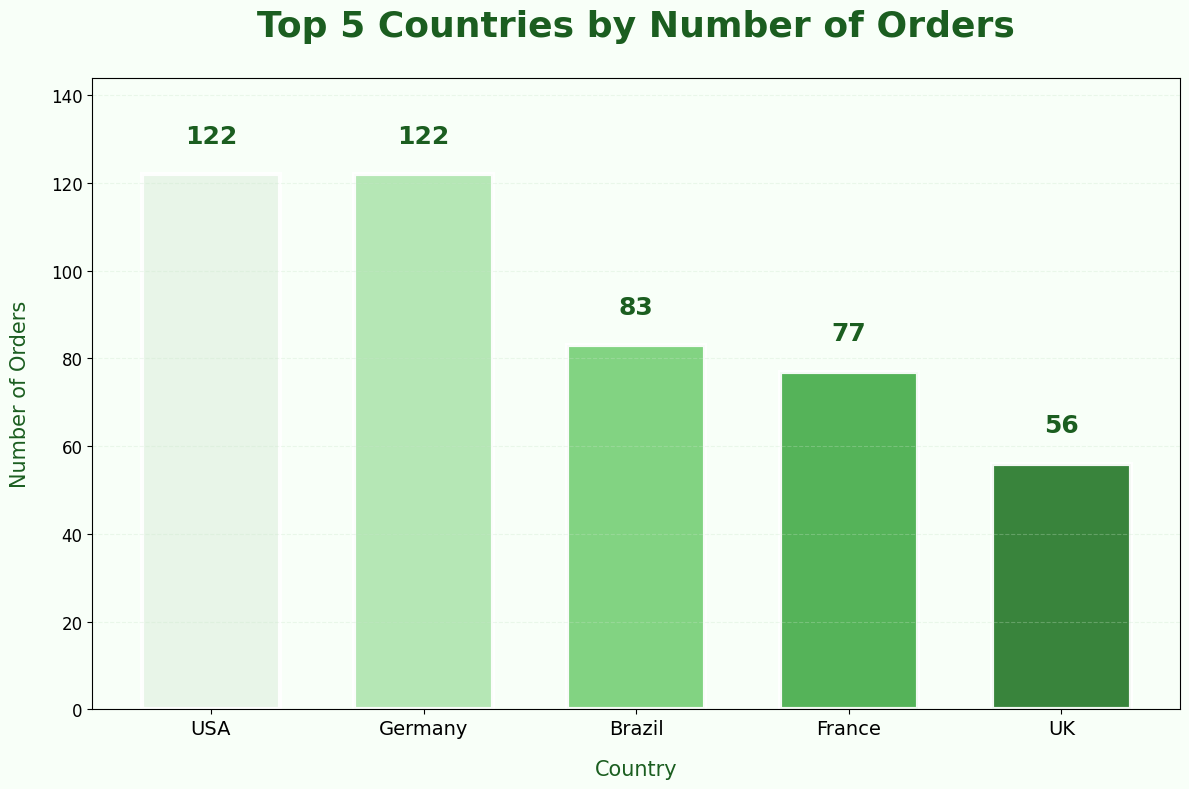

In [ ]:

# Your data (already executed)
df_top5 = run_query(query_top_countries)

# Gorgeous green gradient – from light mint to deep forest
green_colors = ['#e8f5e8', '#b2e6b2', '#7cd17c', '#4caf50', '#2e7d32']

plt.figure(figsize=(12, 8))

bars = plt.bar(df_top5['ShipCountry'],
               df_top5['OrdersCount'],
               color=green_colors,
               edgecolor='white',
               linewidth=3,
               width=0.65,
               alpha=0.95)

# Title & labels in premium green style
plt.title('Top 5 Countries by Number of Orders',
          fontsize=26, fontweight='bold', pad=30, color='#1b5e20')
plt.xlabel('Country', fontsize=15, labelpad=15, color='#1b5e20')
plt.ylabel('Number of Orders', fontsize=15, labelpad=15, color='#1b5e20')

# Big bold numbers on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 6,
             f'{int(height):,}',           # adds comma for thousands
             ha='center',
             va='bottom',
             fontsize=18,
             fontweight='bold',
             color='#1b5e20')

# Final touches
plt.ylim(0, df_top5['OrdersCount'].max() * 1.18)
plt.grid(axis='y', alpha=0.3, linestyle='--', color='#c8e6c9')
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Light green background for extra beauty
plt.gca().set_facecolor('#f8fff8')
plt.gcf().patch.set_facecolor('#f8fff8')

plt.tight_layout()
plt.show()